# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools

In [7]:
import matplotlib.pyplot as plt

In [36]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import mean_squared_error

In [152]:
from numpy import linalg as LA

### Отключим предупреждения Anaconda

In [2]:
warnings.simplefilter('ignore')

# Загрузим данные

In [298]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS_continue_2020/y.pkl.gz', 'rb'))

# N-PLS1

# Приближение к правильному алгоритму

 ### Опишу ка я центрирование в виде класса, для удобства.

In [299]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=0.2857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean()
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def centering_2(self, xx, yy):
        """" Хочу попробовать вариант с заданием у как весов, т.е что бы сумма обновлённых у была равна 1"""
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        self.y_sum=sum(y_centrir)
        y_centrir=y_centrir/sum(y_centrir)
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train_2=X_train_2
        self.X_test_2=X_test_2
        self.y_train_2=y_train_2
        self.y_test_2=y_test_2
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        
    

In [300]:
data=centrir()

In [301]:
data_2=data.centering_and_cv(Xdata_numpy["X"],Ydata)

In [302]:
data_2.y_train

array([-18.58347562,   6.32746173,  -4.27022686,  -1.37197484,
        -4.29886423,   2.44997086,   2.1530446 ,  -5.80157011,
         9.41508832,  -5.9241844 ,  -0.09283701,   4.05467602,
        -3.08549775,  -8.58399134,   5.45213345,   8.0015989 ,
        -4.59584285,  13.72131031,  -3.5147186 ,   7.58267641,
       -11.81077856,   4.55217322,  -5.7521935 ,  -3.88210493,
        -3.76842976])

In [108]:
data_3=data.centering_2(Xdata_numpy["X"],Ydata)

#### Сразу создам файл для выгрузки результатов этого шага построения модели, что б, когда работа будет идти на финальной стадии, не обучаться с нуля

In [33]:
pkl.dump(output,open('C:/Users/admin/Desktop/PLS_continue_2020/output.pkl.gz', 'wb'))

# Попробую оформить всё в виде полноценного класса

In [46]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### Переделаю класс с учётом твоих замечаний и так, чтобы его можно было загнать в GridSearchCV

In [303]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2, *,  tol=1e-06):
        self.n_components = n_components
        self.tol = tol
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        print("aaa")
        return self
    
    def predict(self, x):
        """" x is a test 3-D centering data."""
        
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        print(self.n_components)
        for f in range(0,self.n_components):
            w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
            w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            mmas=np.kron(Tt[:,f].reshape(x.shape[0]),np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas) 
            
        """" В функции fit мы двигались от исходных у к 0, а здесь нужно идти наоборот. И для этого нужен коэффициент bf"""
        y_find=np.zeros([x.shape[0],self.n_components])
        Tt=Tt.reshape(x.shape[0],self.n_components)
        
        y=np.random.normal(0, math.sqrt(self.train_error), x.shape[0])
        for f in range(0,self.n_components):
            size_T=self.n_components-f
            T_part=Tt[:,0:size_T]
            bf=self.bf_array[size_T-1]
            y=y+(np.dot(T_part,bf))
        
        
        return y

In [304]:
%%time


#начинаем применять
regressioModel=Tri_PLS1_grid()
parametrsNames={ 
    'n_components': range(1,18), 
    'tol': [1e-06]
}

gridCought=GridSearchCV(regressioModel, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(data_2.X_train,data_2.y_train)


print(gridCought.best_params_)

aaa
1
1
aaa
1
1
aaa
1
1
aaa
1
1
aaa
1
1
aaa
2
2
aaa
2
2
aaa
2
2
aaa
2
2
aaa
2
2
aaa
3
3
aaa
3
3
aaa
3
3
aaa
3
3
aaa
3
3
aaa
4
4
aaa
4
4
aaa
4
4
aaa
4
4
aaa
4
4
aaa
5
5
aaa
5
5
aaa
5
5
aaa
5
5
aaa
5
5
aaa
6
6
aaa
6
6
aaa
6
6
aaa
6
6
aaa
6
6
aaa
7
7
aaa
7
7
aaa
7
7
aaa
7
7
aaa
7
7
aaa
8
8
aaa
8
8
aaa
8
8
aaa
8
8
aaa
8
8
aaa
9
9
aaa
9
9
aaa
9
9
aaa
9
9
aaa
9
9
aaa
10
10
aaa
10
10
aaa
10
10
aaa
10
10
aaa
10
10
aaa
11
11
aaa
11
11
aaa
11
11
aaa
11
11
aaa
11
11
aaa
12
12
aaa
12
12
aaa
12
12
aaa
12
12
aaa
12
12
aaa
13
13
aaa
13
13
aaa
13
13
aaa
13
13
aaa
13
13
aaa
14
14
aaa
14
14
aaa
14
14
aaa
14
14
aaa
14
14
aaa
15
15
aaa
15
15
aaa
15
15
aaa
15
15
aaa
15
15
aaa
16
16
aaa
16
16
aaa
16
16
aaa
16
16
aaa
16
16
aaa
17
17
aaa
17
17
aaa
17
17
aaa
17
17
aaa
17
17
aaa
{'n_components': 4, 'tol': 1e-06}
Wall time: 38.6 s


In [275]:
import matplotlib as mpl

In [276]:
gridCought.best_estimator_

Tri_PLS1_grid(n_components=7, tol=1e-06)

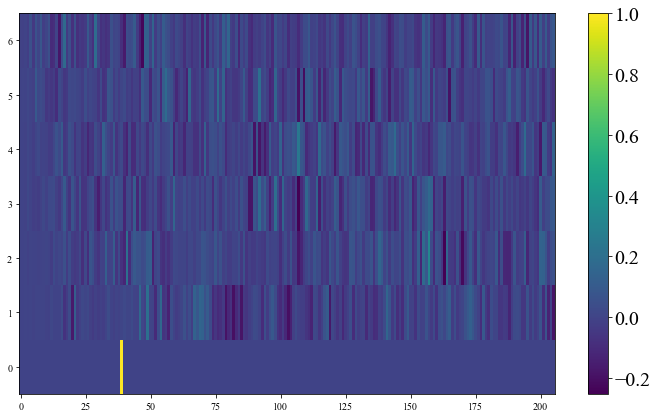

In [182]:
W=gridCought.best_estimator_.w_k

W=W.reshape([7,206])
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(W,aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

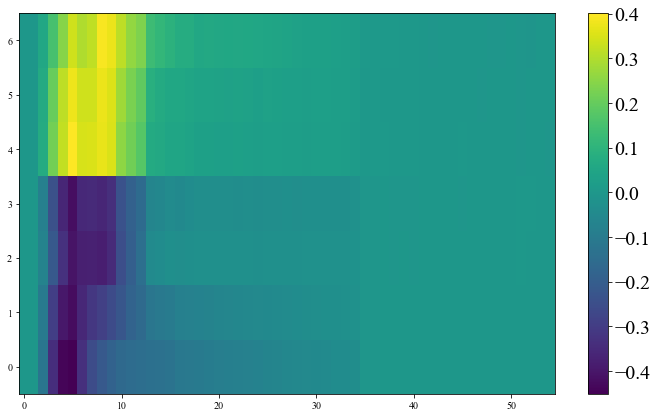

In [128]:
T=gridCought.best_estimator_.w_i
T=T.reshape([7,55])
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(T,aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

In [77]:
np.dot(T.transpose(),W)

array([[ 8.97856326e-08, -3.27021288e-06, -4.03877148e-05, ...,
        -5.52880573e-07,  1.30943768e-04,  3.45930885e-05],
       [-3.93538197e-07, -1.90188271e-05, -3.67804162e-05, ...,
         4.64405665e-05,  1.15277256e-04,  1.10796786e-04],
       [-2.48987864e-04, -1.19331634e-03,  7.63060257e-03, ...,
         1.54785070e-02, -1.13615331e-02, -6.71682806e-03],
       ...,
       [-5.40175814e-07, -4.68915399e-05, -5.13959733e-05, ...,
         6.77836861e-05,  1.29790261e-04,  2.20113430e-04],
       [-7.97007906e-07, -4.01595790e-05, -2.08777696e-05, ...,
         8.75709302e-05,  4.40165223e-05,  1.96945652e-04],
       [-4.52438561e-07, -3.01160721e-05, -8.81504234e-06, ...,
         5.34088303e-05, -3.23683390e-07,  1.43723983e-04]])

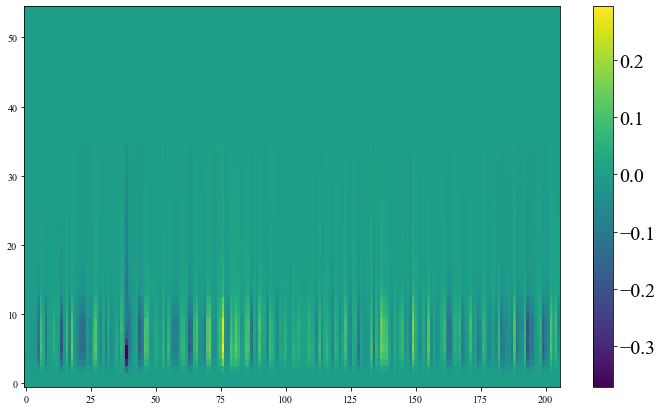

In [129]:
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(np.dot(T.transpose(),W),aspect="auto", origin='lower')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

plt.show();

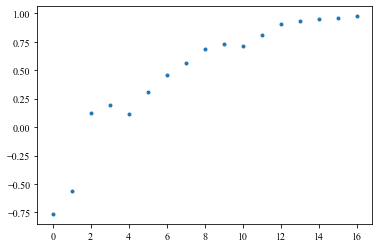

In [305]:
plt.plot(gridCought.cv_results_[ "mean_train_score" ],".")
plt.show();

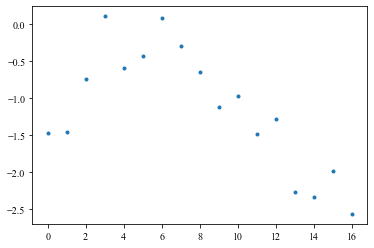

In [306]:
plt.plot(gridCought.cv_results_[ "mean_test_score" ],".")
plt.show();

In [307]:
gridCought.cv_results_[ "mean_test_score" ]

array([-1.46900515, -1.46010796, -0.73898591,  0.10244183, -0.59651483,
       -0.43007267,  0.08052365, -0.30380396, -0.64515526, -1.11773238,
       -0.97275256, -1.48363051, -1.28494176, -2.26216859, -2.32914982,
       -1.98287445, -2.56331133])

In [118]:
gridCought.score(X_test,y_test)

NameError: name 'X_test' is not defined

In [261]:
r2_score(y_test, gridCought.predict(X_test))

7


0.3782483389712997

In [156]:
b=Tri_PLS1_grid(10)

In [157]:
for i in range(0,1):
    b.fit(X_train,y_train)

In [158]:
b.predict(X_test)

10


array([-3.60979414, -1.90610219,  3.88842363, -3.58264326, -3.30159225,
       12.05308735, -4.13845848, -6.75562827,  3.70127468, 10.81225349])

In [159]:
r2_score(y_test, b.predict(X_test))

10


0.26233076945872946

### Старый вариант класса. Ниже этой клетки можно в принципе и не проверять.

In [311]:
class Tri_PLS1_first(BaseEstimator, RegressorMixin):
    def  __init__(self, n_components=2, *, max_iter=500, tol=1e-06, copy=True):
        self.n_components = n_components
        self.max_iter = max_iter # Пока в ней нет необходимости. Прописал для общего фона.
        self.tol = tol
        self.copy = copy
        
    
    def fit(self, x, y):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray, which was centering before running this code
            tensor data of shape (n_samples, N1, ..., NS)
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=y
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения, и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            t=np.zeros([x.shape[0]])
            for h in range(0,x.shape[0]):
                t[h]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            t=np.array(t).reshape(x.shape[0])
            Tt[:,f]=t
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(t,np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
            output[f]=mean_squared_error(mass,y_copy)
        # Оставил только чтобы контролировать воспроизводимость и адекватность. 
        plt.plot(output)
        plt.show();
        self.bf_array=bf_array
        self.train_error=output
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        return self
    
    def predict(self, x, y_test):
        """" x is a test 3-D centering data."""
        Tt=np.zeros([x.shape[0],self.n_components])
        output=np.zeros([self.n_components])
        for f in range(0,self.n_components):
            w_k=np.array(self.w_k[f,:,:]).reshape(x.shape[1],1)
            w_i=np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
            t=np.zeros([x.shape[0]])
            for h in range(0,x.shape[0]):
                t[h]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            t=np.array(t).reshape(x.shape[0])
            Tt[:,f]=t
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            mmas=np.kron(t,np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas) 
            
        """" В функции fit мы двигались от исходных у к 0, а здесь нужно идти наоборот. И для этого нужен коэффициент bf"""
        y_find=np.zeros([x.shape[0],self.n_components])
        for d in range(0,self.n_components):
            y=np.random.normal(0, math.sqrt(self.train_error[d]), x.shape[0])
            for f in range(0,d+1):
                size_T=d+1-f
                T_part=T[:,0:size_T]
                bf=self.bf_array[size_T-1]
                y=y+(np.dot(T_part,bf))
            y_find[:,d]=y
            if (((d-6)<0.9) and ((d-6)>(-0.9))):
                print(y)
                print(y_test)
            output[d]=mean_squared_error(y,y_test)
        plt.plot(output)
        plt.show();
        self.test_error=output
        self.y_find=y_find
        return self

In [312]:
a=Tri_PLS1_first(17)

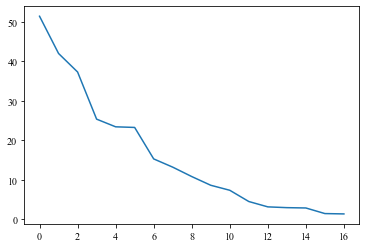

In [313]:
for i in range(0,1):
    a.fit(data_2.X_train,data_2.y_train)

[16.3690397   8.35658588  4.8764599   4.08315744 -1.10566639 -0.21604375
  3.52041394 -4.68734611  1.21353032 -3.09259296]
[ 14.64600637  -6.65260834   3.27807984  -4.64005226   4.40507881
   1.0451428   16.05197918 -13.79718301  -0.15706949   7.44718265]


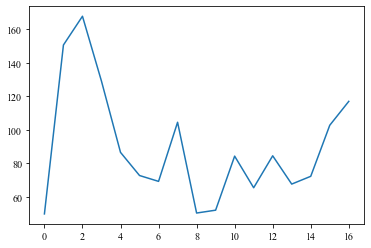

In [314]:
for i in range(0,1):
    a.predict(data_2.X_test,data_2.y_test)

In [80]:
a.y_find.shape

(10, 17)

In [317]:
r2_score(data_2.y_test, a.y_find[:,8])

0.34573519134502084

In [316]:
from sklearn.metrics import r2_score

In [23]:
y_test9=y_test+asas
y_test99=a.y_find[:,6]+asas

In [24]:
mean_squared_error(y_test9,y_test99)

46.35540667228468

In [25]:
y_test

array([  4.55217322,   3.27807984,  -6.65260834,  -4.64005226,
        -0.15706949, -11.81077856,  -5.7521935 ,  -8.58399134,
        -1.37197484,   9.41508832])

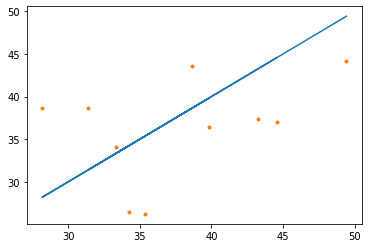

In [26]:
plt.plot(y_test9,y_test9)
plt.plot(y_test9,y_test99,".")
plt.show()

### Дальше идут черновики, и прочие нефункциональные или тренировочные элементы.

In [84]:
a

N_PLS1_first(copy=True, max_iter=500, n_components=27, norm_y_weights=False,
             scale=True, tol=1e-06)

In [ ]:
.reshape(x.shape[0],1)
-np.array(mass).reshape(1,x.shape[0]).mean()

In [179]:
y

array([34.19308759, 35.72443085, 46.32211944, 35.69579348, 47.44184036,
       33.34204937, 42.44462856, 39.9018207 , 44.39973652, 54.64066407,
       53.71596802, 44.04933373, 36.11255278, 34.24246421, 36.22622795,
       26.1974747 , 41.0398005 , 31.41066637, 34.07047331, 42.14770231,
       45.44679116, 21.41118209, 44.54683093, 35.35460545, 36.47993911])

In [395]:
output=np.zeros([parameters['numbers_of_components']])
for v in range(0,parameters['numbers_of_learning']):
    X_train, X_test, y_train, y_test = train_test_split(
        Xdata_numpy["X"], Ydata.iloc[:,parameters['column_y']], test_size=parameters['testSize'] 
        )
    x=X_train
    y=y_train
    y=np.array(y)
    x=np.array(x)
    Tt=[]
    mass=np.zeros([y.shape[0]])
    for f in range(0,parameters['numbers_of_components']):
        z=np.zeros([x.shape[1],x.shape[2]])
        for i in range(0,x.shape[2]):
            for j in range(0,x.shape[1]):
                zsum=0
                for k in range(0,x.shape[0]):
                    zsum= zsum+ x[k,j,i]*y[k]
                z[j,i]=zsum
        Wk, S, WI = np.linalg.svd(z)
        w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
        w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
        t=[]
        for h in range(0,x.shape[0]):
            t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
        t=np.array(t).reshape(x.shape[0],1)
        Tt+=[t]
        T=np.array(Tt).reshape(x.shape[0],f+1)
        bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
        mmas=np.kron(np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])
        
        for g in range(0,x.shape[0]):
            x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
        y=y-(np.dot(T,bf))
        mass+=np.dot(T,bf)   
        output[f]+=error(mass,y_train)
np.array(output).reshape(1,parameters['numbers_of_components'])

array([[5.20396143e+04, 4.91918971e+04, 4.38839916e+04, 3.88590076e+04,
        3.28461510e+04, 2.71640444e+04, 2.06742360e+04, 1.51864921e+04,
        1.08940127e+04, 7.45914196e+03, 5.10460116e+03, 3.13773457e+03,
        1.85325287e+03, 8.68438137e+02, 4.09180232e+02, 2.46334649e+02,
        1.76439608e+02, 1.32129844e+02, 1.09666897e+02, 8.20938712e+01,
        4.59856659e+01, 2.60763430e+01, 1.10681096e+01, 4.58247849e+00,
        9.94812128e-01, 1.09443246e-07, 1.55442375e-08, 1.07111515e-08,
        4.36357780e-09, 8.25991184e-09, 8.28521838e-09, 3.91514087e-08,
        4.05800265e-07, 9.57270667e-08, 3.17840084e-06, 2.82484373e-06,
        6.49010797e-07, 2.30233617e-04, 7.71299123e-03, 1.62744298e-01,
        6.11296107e+01, 1.03835530e+03, 1.01042473e+03, 4.74122861e+03,
        6.23619775e+04, 9.49571644e+04, 1.22425553e+06, 5.50510253e+06,
        5.15620269e+06, 4.28673709e+06, 1.03028491e+09, 1.22720823e+12,
        9.71049882e+14, 6.76286674e+15, 4.44894505e+18]])

In [75]:
pp=np.array([[[1,2],[3,4]],[[5,6],[7,8]]])

In [76]:
pp

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [77]:
yu=np.array([1,2])

In [100]:
print(type(pp))

<class 'numpy.ndarray'>


In [78]:
np.dot(pp[1,:,:],yu[1])

array([[10, 12],
       [14, 16]])

In [286]:
x=X_train
y=y_train
y=np.array(y)
x=np.array(x)
Tt=[]
output=np.zeros([parameters['numbers_of_components']])
mass=np.zeros([y.shape[0]])
kk=[]
for f in range(0,parameters['numbers_of_components']):
    z=np.zeros([x.shape[1],x.shape[2]])
    x_product=np.zeros([y.shape[0],x.shape[1],x.shape[2]])
    for i in range(0,y.shape[0]):
        x_product[i,:,:]=np.dot(x[i,:,:],y[i])
    z=x_product.sum(axis=0)
    Wk, S, WI = np.linalg.svd(z)
    w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
    w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
    
    t=[]
    for h in range(0,x.shape[0]):
        t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
    t=np.array(t).reshape(x.shape[0],1)
    Tt+=[t]
    T=np.array(Tt).reshape(x.shape[0],f+1)
    bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
    kk+=[bf]
    for g in range(0,x.shape[0]):
        x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
    y=y-(np.dot(T,bf))
    mass+=np.dot(T,bf)   
    output[f]+=mean_squared_error(mass,y_train)
print(kk)
fgffgffgfgf=np.array(output).reshape(1,parameters['numbers_of_components'])

[array([-1.66118692]), array([-6.29079172,  6.73688692]), array([-4.12522941,  1.04501877, -5.43633477]), array([-2.47312785, -0.77091171, -3.58375233,  0.30593637]), array([16.50410601, -5.00622902, -8.22588722,  1.24655259,  3.29071373]), array([-4.19790957, -2.35053163,  0.98214464,  0.34894549, -0.05205299,
        0.86235296]), array([-1.87063411,  0.91027459, -0.09391723,  0.92112484, -2.92076064,
        0.98227647, -0.96633831]), array([-3.40181009,  0.31731486,  0.53363854,  1.63610577,  0.3901178 ,
        2.24601301, -1.17585434, -0.2064675 ]), array([-0.44467154,  0.55624498, -0.64257114, -0.23228063,  0.52400954,
       -0.46183266, -0.72497265,  0.01414457,  0.54696848]), array([-9.11867149,  5.3415317 , 11.71030015, -3.67531275, -0.65128271,
        8.63820213, -5.58461098, -5.64958101,  0.19695864,  3.50070102]), array([-0.5694123 , -0.15692167,  0.21129866, -0.18233175,  0.30182872,
       -0.26179883,  0.48778146, -0.24362274,  0.02664971, -0.19194008,
        0.84289

In [79]:
pp.sum(axis=0)

array([[ 6,  8],
       [10, 12]])

In [125]:
vv=np.kron(np.array([7,6]),pp)

In [126]:
vv

array([[[ 7, 14,  6, 12],
        [21, 28, 18, 24]],

       [[35, 42, 30, 36],
        [49, 56, 42, 48]]])

In [130]:
vv[0,0,0:1]

array([7])

In [219]:
j=np.array([1,2,3])
jj=np.array([4,5,6])
jjj=np.array([7,8,9])

In [195]:
np.dot(ggg,j)

array([[32],
       [64],
       [96]])

In [191]:
j*jj

array([ 4, 10, 18])

In [192]:
j*ggg

array([[ 4, 10, 18],
       [ 8, 20, 36],
       [12, 30, 54]])

In [172]:
gg=j*jj.transpose()

In [178]:
gg

array([ 4, 10, 18])

In [181]:
ggg=np.kron(j,jj.transpose()).reshape(3,3)

In [184]:
ggg

array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])

In [252]:
ggg*2

array([[ 8, 10, 12],
       [16, 20, 24],
       [24, 30, 36]])

In [183]:
np.kron(jjj,ggg).reshape(3,3,3)

array([[[ 28,  35,  42],
        [ 32,  40,  48],
        [ 36,  45,  54]],

       [[ 56,  70,  84],
        [ 64,  80,  96],
        [ 72,  90, 108]],

       [[ 84, 105, 126],
        [ 96, 120, 144],
        [108, 135, 162]]])

In [218]:
fff=np.kron(jjj,ggg).reshape(3,3,3)

In [225]:
np.dot(fff[0,:,:],j[1])

array([[ 56,  70,  84],
       [ 64,  80,  96],
       [ 72,  90, 108]])

In [ ]:
# пока в планах
class N_PLS1():
    def error(a,b):
        s=0
        for i in range(0,len(a)):
            s+=((a[i]-b.iloc[i]))**2
        return s
    def function_1(x,y,fn):
        Tt=[]
        mass=np.zeros([y.shape[0]])
        output=[]
        for f in range(0,fn):
            z=np.zeros([x.shape[1],x.shape[2]])
            for i in range(0,x.shape[2]):
                for j in range(0,x.shape[1]):
                    zsum=0
                    for k in range(0,x.shape[0]):
                        zsum= zsum+ x[k,j,i]*y[k]
                    z[j,i]=zsum
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            t=[]
            for h in range(0,x.shape[0]):
                t+=[np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)]
            t=np.array(t).reshape(x.shape[0],1)
            Tt+=[t]
            T=np.array(Tt).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            for g in range(0,x.shape[0]):
                x[g,:,:]=x[g,:,:]-(t[g]*w_i.transpose()*w_k)
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)
            output+=[error(mass,y_train)]
        return output
    def fit(x,y,fn):
        
            
        return y